# Coherent One-Way (COW) Quantum Key Distribution Protocol

This notebook implements the COW QKD protocol using Qiskit.

## Protocol Overview
- **Alice** sends sequences of weak coherent pulses in two time bins
- **Bob** performs measurements to detect eavesdropping and generate keys
- Security relies on the no-cloning theorem and coherence monitoring

In [10]:
# Install required packages
!pip install qiskit qiskit-aer matplotlib numpy scipy -q

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

## 1. COW Protocol Implementation

In the COW protocol:
- Alice sends either **|0⟩|0⟩** (decoy) or **|0⟩|1⟩** (bit 0) or **|1⟩|0⟩** (bit 1)
- Bob measures in computational basis for key generation
- Bob performs interference measurements to detect eavesdropping

In [14]:
class COWProtocol:
    def __init__(self, key_length=100, decoy_probability=0.2, noise_level=0.0):
        self.key_length = key_length
        self.decoy_prob = decoy_probability
        self.noise_level = noise_level
        self.backend = AerSimulator()
        
        # Protocol data
        self.alice_bits = []
        self.alice_sequence = []  # 0: decoy, 1: data
        self.bob_measurements = []
        self.raw_key_alice = []
        self.raw_key_bob = []
        
    def alice_prepare_state(self, bit_value, is_decoy=False):
        qr = QuantumRegister(2, 'time_bin')
        cr = ClassicalRegister(2, 'measure')
        qc = QuantumCircuit(qr, cr)
        
        if is_decoy:
            pass  # Decoy state: |00⟩
        else:
            if bit_value == 0:
                qc.x(qr[1])  # Bit 0: |01⟩
            else:
                qc.x(qr[0])  # Bit 1: |10⟩
        
        # Add noise
        if self.noise_level > 0:
            for i in range(2):
                if np.random.random() < self.noise_level:
                    qc.x(qr[i])
        
        return qc, qr, cr
    
    def bob_measure_data(self, qc, qr, cr):
        qc.measure(qr, cr)
        return qc
    
    def bob_measure_interference(self, qc, qr, cr):
        qc.h(qr[0])
        qc.h(qr[1])
        qc.measure(qr, cr)
        return qc
    
    def run_protocol(self):
        print(f'Starting COW QKD Protocol...')
        print(f'Target key length: {self.key_length}')
        print(f'Decoy probability: {self.decoy_prob}')
        print(f'Noise level: {self.noise_level}\n')
        
        iteration = 0
        while len(self.raw_key_alice) < self.key_length:
            iteration += 1
            
            is_decoy = np.random.random() < self.decoy_prob
            
            if is_decoy:
                bit_value = None
                self.alice_sequence.append(0)
            else:
                bit_value = np.random.randint(0, 2)
                self.alice_bits.append(bit_value)
                self.alice_sequence.append(1)
            
            qc, qr, cr = self.alice_prepare_state(bit_value, is_decoy)
            
            measure_type = np.random.choice(['data', 'interference'], p=[0.9, 0.1])
            
            if measure_type == 'data':
                qc = self.bob_measure_data(qc, qr, cr)
            else:
                qc = self.bob_measure_interference(qc, qr, cr)
            
            compiled_circuit = transpile(qc, self.backend)
            job = self.backend.run(compiled_circuit, shots=1)
            result = job.result()
            counts = result.get_counts()
            measurement = list(counts.keys())[0]
            
            self.bob_measurements.append(measurement)
            
            if not is_decoy and measure_type == 'data':
                if measurement == '01':
                    bob_bit = 0
                elif measurement == '10':
                    bob_bit = 1
                else:
                    continue
                
                self.raw_key_alice.append(bit_value)
                self.raw_key_bob.append(bob_bit)
        
        print(f'Protocol completed after {iteration} transmissions')
        return self.analyze_results()
    
    def analyze_results(self):
        errors = sum(a != b for a, b in zip(self.raw_key_alice, self.raw_key_bob))
        qber = errors / len(self.raw_key_alice) if self.raw_key_alice else 0
        efficiency = len(self.raw_key_alice) / len(self.alice_sequence)
        
        results = {
            'key_length': len(self.raw_key_alice),
            'qber': qber,
            'efficiency': efficiency,
            'total_transmissions': len(self.alice_sequence),
            'decoy_count': self.alice_sequence.count(0),
            'alice_key': self.raw_key_alice,
            'bob_key': self.raw_key_bob
        }
        
        print(f'\n=== Protocol Results ===')
        print(f'Key length: {results["key_length"]} bits')
        print(f'QBER: {qber*100:.2f}%')
        print(f'Efficiency: {efficiency*100:.2f}%')
        print(f'Total transmissions: {results["total_transmissions"]}')
        print(f'Decoy states sent: {results["decoy_count"]}')
        
        return results

## 2. Run the Protocol

In [15]:
cow = COWProtocol(key_length=50, decoy_probability=0.2, noise_level=0.05)
results = cow.run_protocol()

Starting COW QKD Protocol...
Target key length: 50
Decoy probability: 0.2
Noise level: 0.05

Protocol completed after 90 transmissions

=== Protocol Results ===
Key length: 50 bits
QBER: 98.00%
Efficiency: 55.56%
Total transmissions: 90
Decoy states sent: 19


## 3. Visualize Sample Quantum Circuits

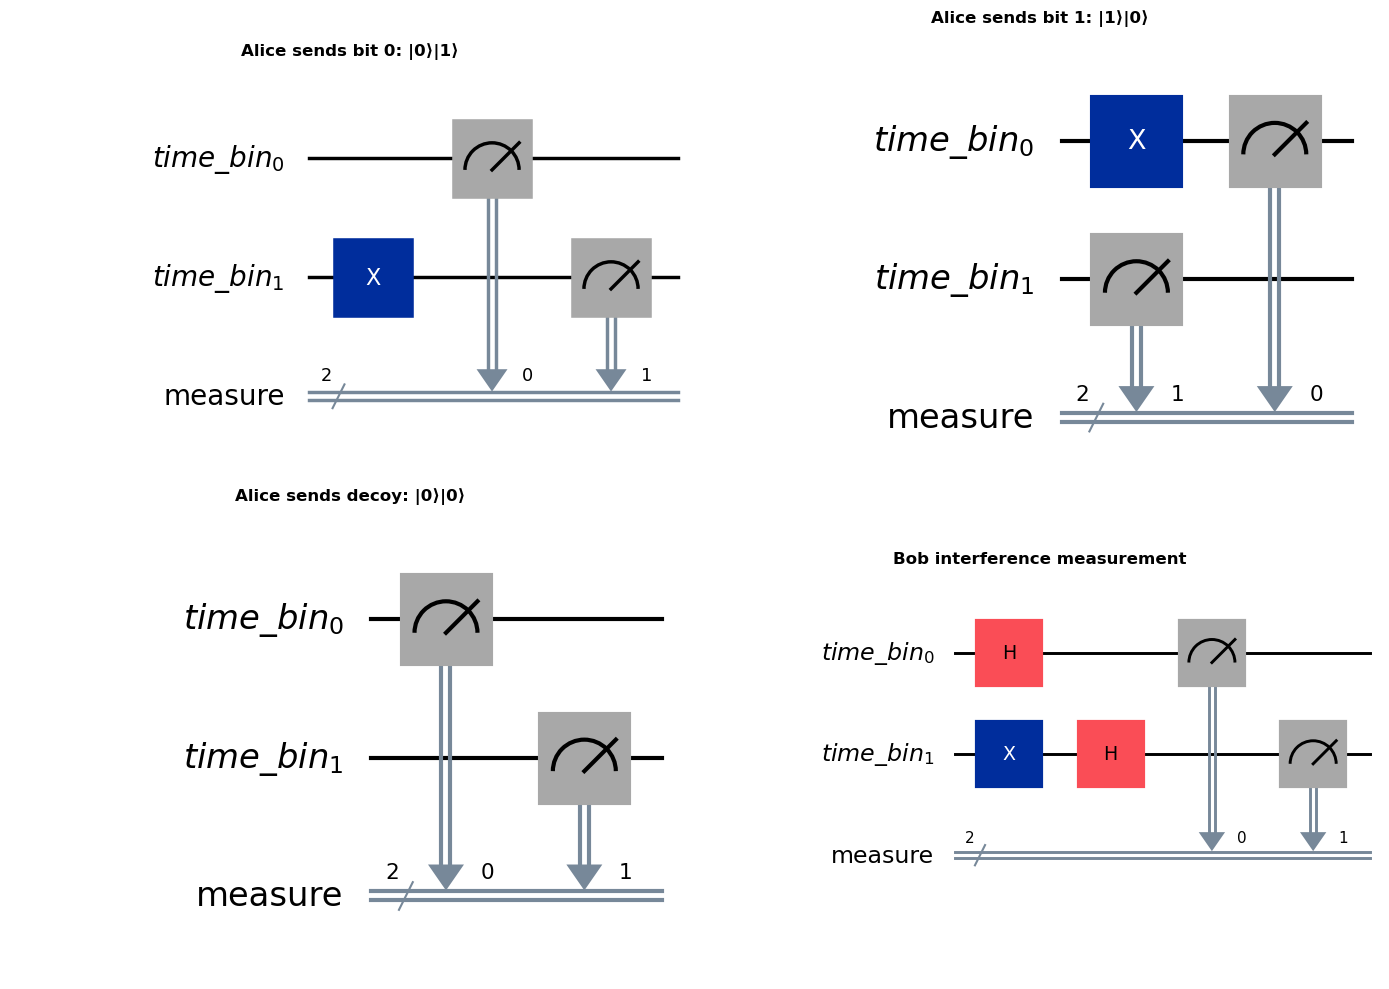

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

qr = QuantumRegister(2, 'time_bin')
cr = ClassicalRegister(2, 'measure')

qc0 = QuantumCircuit(qr, cr)
qc0.x(qr[1])
qc0.measure(qr, cr)
qc0.draw('mpl', ax=axes[0, 0])
axes[0, 0].set_title('Alice sends bit 0: |0⟩|1⟩', fontsize=12, fontweight='bold')

qc1 = QuantumCircuit(qr, cr)
qc1.x(qr[0])
qc1.measure(qr, cr)
qc1.draw('mpl', ax=axes[0, 1])
axes[0, 1].set_title('Alice sends bit 1: |1⟩|0⟩', fontsize=12, fontweight='bold')

qc_decoy = QuantumCircuit(qr, cr)
qc_decoy.measure(qr, cr)
qc_decoy.draw('mpl', ax=axes[1, 0])
axes[1, 0].set_title('Alice sends decoy: |0⟩|0⟩', fontsize=12, fontweight='bold')

qc_int = QuantumCircuit(qr, cr)
qc_int.x(qr[1])
qc_int.h(qr[0])
qc_int.h(qr[1])
qc_int.measure(qr, cr)
qc_int.draw('mpl', ax=axes[1, 1])
axes[1, 1].set_title('Bob interference measurement', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Visualize Protocol Performance

Testing protocol with varying noise levels...

Starting COW QKD Protocol...
Target key length: 100
Decoy probability: 0.2
Noise level: 0.0

Protocol completed after 136 transmissions

=== Protocol Results ===
Key length: 100 bits
QBER: 100.00%
Efficiency: 73.53%
Total transmissions: 136
Decoy states sent: 23
Noise: 0.000 | QBER: 100.00% | Efficiency: 73.53%
Starting COW QKD Protocol...
Target key length: 100
Decoy probability: 0.2
Noise level: 0.022222222222222223

Protocol completed after 141 transmissions

=== Protocol Results ===
Key length: 100 bits
QBER: 100.00%
Efficiency: 70.92%
Total transmissions: 141
Decoy states sent: 26
Noise: 0.022 | QBER: 100.00% | Efficiency: 70.92%
Starting COW QKD Protocol...
Target key length: 100
Decoy probability: 0.2
Noise level: 0.044444444444444446

Protocol completed after 138 transmissions

=== Protocol Results ===
Key length: 100 bits
QBER: 100.00%
Efficiency: 72.46%
Total transmissions: 138
Decoy states sent: 25
Noise: 0.044 | QBER: 100.00% |

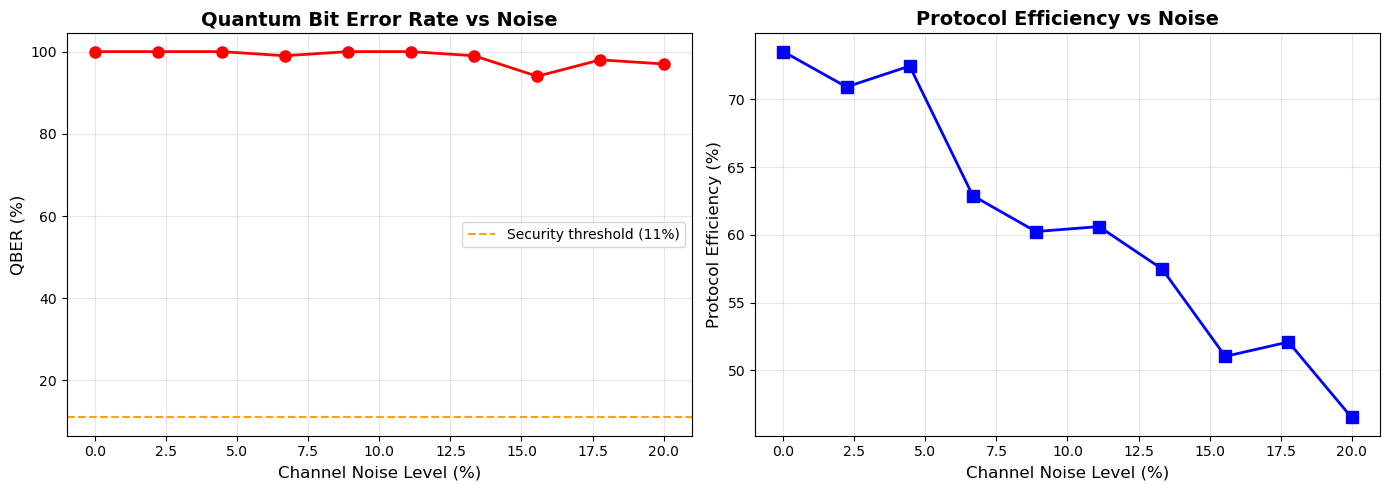

In [7]:
noise_levels = np.linspace(0, 0.2, 10)
qbers = []
efficiencies = []

print('Testing protocol with varying noise levels...\n')
for noise in noise_levels:
    cow_test = COWProtocol(key_length=100, decoy_probability=0.2, noise_level=noise)
    results_test = cow_test.run_protocol()
    qbers.append(results_test['qber'] * 100)
    efficiencies.append(results_test['efficiency'] * 100)
    print(f'Noise: {noise:.3f} | QBER: {results_test["qber"]*100:.2f}% | Efficiency: {results_test["efficiency"]*100:.2f}%')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(noise_levels * 100, qbers, 'o-', linewidth=2, markersize=8, color='red')
axes[0].axhline(y=11, color='orange', linestyle='--', label='Security threshold (11%)')
axes[0].set_xlabel('Channel Noise Level (%)', fontsize=12)
axes[0].set_ylabel('QBER (%)', fontsize=12)
axes[0].set_title('Quantum Bit Error Rate vs Noise', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].plot(noise_levels * 100, efficiencies, 's-', linewidth=2, markersize=8, color='blue')
axes[1].set_xlabel('Channel Noise Level (%)', fontsize=12)
axes[1].set_ylabel('Protocol Efficiency (%)', fontsize=12)
axes[1].set_title('Protocol Efficiency vs Noise', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Key Comparison Visualization

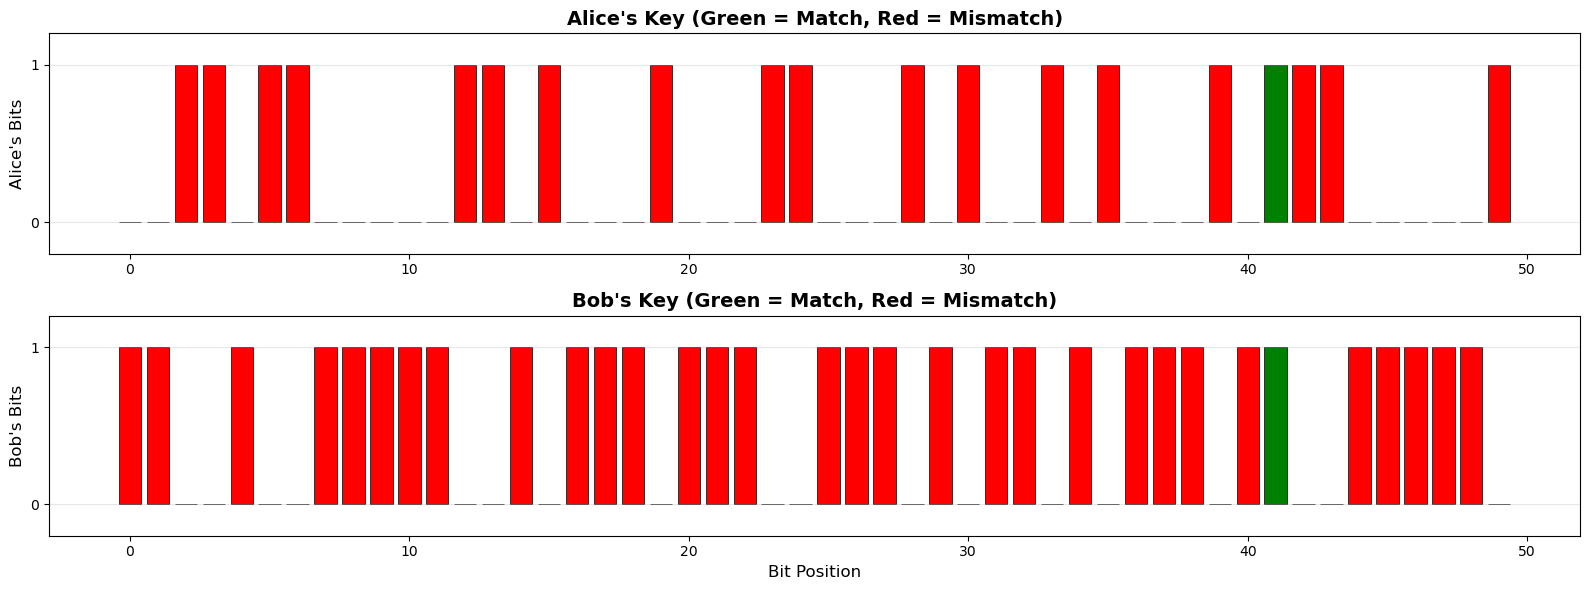


Showing first 50 bits
Matching bits: 1
Mismatched bits: 49
Error rate: 98.00%


In [8]:
display_length = min(50, len(results['alice_key']))
alice_display = results['alice_key'][:display_length]
bob_display = results['bob_key'][:display_length]

mismatches = [i for i in range(display_length) if alice_display[i] != bob_display[i]]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 6))

colors_alice = ['green' if i not in mismatches else 'red' for i in range(display_length)]
ax1.bar(range(display_length), alice_display, color=colors_alice, edgecolor='black', linewidth=0.5)
ax1.set_ylabel("Alice's Bits", fontsize=12)
ax1.set_title("Alice's Key (Green = Match, Red = Mismatch)", fontsize=14, fontweight='bold')
ax1.set_ylim(-0.2, 1.2)
ax1.set_yticks([0, 1])
ax1.grid(True, alpha=0.3, axis='y')

colors_bob = ['green' if i not in mismatches else 'red' for i in range(display_length)]
ax2.bar(range(display_length), bob_display, color=colors_bob, edgecolor='black', linewidth=0.5)
ax2.set_xlabel('Bit Position', fontsize=12)
ax2.set_ylabel("Bob's Bits", fontsize=12)
ax2.set_title("Bob's Key (Green = Match, Red = Mismatch)", fontsize=14, fontweight='bold')
ax2.set_ylim(-0.2, 1.2)
ax2.set_yticks([0, 1])
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f'\nShowing first {display_length} bits')
print(f'Matching bits: {display_length - len(mismatches)}')
print(f'Mismatched bits: {len(mismatches)}')
print(f'Error rate: {len(mismatches)/display_length*100:.2f}%')

## 6. Security Analysis

In [9]:
def analyze_security(qber):
    threshold = 0.11
    
    print('\n=== Security Analysis ===')
    print(f'Current QBER: {qber*100:.2f}%')
    print(f'Security threshold: {threshold*100:.2f}%\n')
    
    if qber < threshold:
        margin = ((threshold - qber) / threshold) * 100
        print(f'✓ SECURE: QBER is {margin:.1f}% below threshold')
        print('  The channel appears secure for key distribution.')
    else:
        excess = ((qber - threshold) / threshold) * 100
        print(f'✗ INSECURE: QBER is {excess:.1f}% above threshold')
        print('  Possible eavesdropping detected!')
    
    if qber < threshold and qber > 0:
        h_qber = -qber * np.log2(qber) - (1-qber) * np.log2(1-qber)
        secure_key_rate = max(0, 1 - 2 * h_qber)
        print(f'\nEstimated secure key rate: {secure_key_rate:.4f} bits/pulse')
    
    return qber < threshold

is_secure = analyze_security(results['qber'])


=== Security Analysis ===
Current QBER: 98.00%
Security threshold: 11.00%

✗ INSECURE: QBER is 790.9% above threshold
  Possible eavesdropping detected!


## Summary

This notebook demonstrated the COW QKD protocol with:
- Time-bin encoding for quantum states
- Decoy states for security monitoring
- QBER calculation and security analysis
- Performance visualization under different noise conditions